# MODELLING
A notebook to model the problem

In [37]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import joblib
import copy
import pandas as pd
import numpy as np
import os
PRJ_ROOT_DIR = os.path.dirname(os.path.abspath(''))

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

In [26]:
# Where to save the figures
NOTE_ROOT_DIR = os.path.abspath('')
CHAPTER_ID = "04_modelling"
IMAGES_PATH = os.path.join(NOTE_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 1 - Load the Data

In [5]:
# Load the integrated data
df_match = pd.read_csv(os.path.join(PRJ_ROOT_DIR, "data", "tabular", "integrate", "matches.csv"))
df_match.drop(['season'], axis=1, inplace=True)
df_match.head()

,home_result,defence/clean_sheets_0,defence/goals_conceded_0,defence/tackles_0,defence/tackle_success_%_0,defence/last_man_tackles_0,defence/blocked_shots_0,defence/interceptions_0,defence/clearances_0,defence/headed_clearance_0,...,goalkeeping/catches_26,goalkeeping/sweeper_clearances_26,goalkeeping/throw_outs_26,goalkeeping/goal_kicks_26,defence/recoveries_26,defence/duels_won_26,defence/duels_lost_26,teamplay/passes_26,teamplay/crosses_26,teamplay/accurate_long_balls_26
0,lose,5.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1097.0,88.0,0.0
1,win,6.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
2,win,13.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
3,win,11.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,248.0,13.0,0.0
4,win,13.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0


### 1.1. Manage Empty Positions' Statistics

In [6]:
# Replace -100 with 0 (statistics' value of empty positions)
df_match = df_match.replace(-100, 0)
df_match.head()

,home_result,defence/clean_sheets_0,defence/goals_conceded_0,defence/tackles_0,defence/tackle_success_%_0,defence/last_man_tackles_0,defence/blocked_shots_0,defence/interceptions_0,defence/clearances_0,defence/headed_clearance_0,...,goalkeeping/catches_26,goalkeeping/sweeper_clearances_26,goalkeeping/throw_outs_26,goalkeeping/goal_kicks_26,defence/recoveries_26,defence/duels_won_26,defence/duels_lost_26,teamplay/passes_26,teamplay/crosses_26,teamplay/accurate_long_balls_26
0,lose,5.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1097.0,88.0,0.0
1,win,6.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,win,13.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,win,11.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,248.0,13.0,0.0
4,win,13.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.2 Create a Test Set

In [7]:
# Split train-test
from sklearn.model_selection import train_test_split
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(df_match.iloc[:, 1:], df_match["home_result"], test_size=test_size, random_state=42)
X_train.head()

,defence/clean_sheets_0,defence/goals_conceded_0,defence/tackles_0,defence/tackle_success_%_0,defence/last_man_tackles_0,defence/blocked_shots_0,defence/interceptions_0,defence/clearances_0,defence/headed_clearance_0,defence/clearances_off_line_0,...,goalkeeping/catches_26,goalkeeping/sweeper_clearances_26,goalkeeping/throw_outs_26,goalkeeping/goal_kicks_26,defence/recoveries_26,defence/duels_won_26,defence/duels_lost_26,teamplay/passes_26,teamplay/crosses_26,teamplay/accurate_long_balls_26
872,8.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
626,10.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
617,9.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
409,11.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
589,9.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.3 - Preprocessing

In [8]:
# Setup the pipeline of preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline

pipe_predictor_preprocess = Pipeline([
    ("scaler", StandardScaler())
])
pipe_label_preprocess = Pipeline([
    ("encoder", OrdinalEncoder())
])

In [9]:
# Transform the training data
X_prep = pipe_predictor_preprocess.fit_transform(X_train)
y_prep = pipe_label_preprocess.fit_transform(y_train.values.reshape(-1, 1))
pipe_label_preprocess["encoder"].categories_

[array(['draw', 'lose', 'win'], dtype=object)]

## 2 - Modelling

In [50]:
# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# Import metrics
from sklearn.metrics import accuracy_score, f1_score

# Import cross-validation and tuning tools
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint, uniform
from skopt import BayesSearchCV
from skopt.space import Real

# Setup to save/load the model
def save_model(model, id_):
    print("Saving model", id_)
    joblib.dump(model, os.path.join(NOTE_ROOT_DIR, "models", CHAPTER_ID, id_ + ".pkl"))
def load_model(id_):
    print("Loading model", id_)
    return joblib.load(os.path.join(NOTE_ROOT_DIR, "models", CHAPTER_ID, id_ + ".pkl"))

# Setup display
def report(y_true, y_pred):
    print("======")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1      :", f1_score(y_true, y_pred, average="micro"))
    print("======")

# Setup cross-validation
def cross_validate(model, X_prep, y_prep, scoring="accuracy", cv=10):
    return cross_val_score(model, X_prep, y_prep, scoring=scoring, cv=cv, verbose=1, n_jobs=3).mean()

# Setup hyperparameter tuning
def randomized_search(
    model,
    X,
    y,
    param_distributions,
    n_iter=50,
    cv=10,
    scoring="accuracy",
    error_score="raise",
    random_state=42
):
    rnd_search = RandomizedSearchCV(model, param_distributions, 
                                    n_iter=n_iter, cv=cv, scoring=scoring, 
                                    error_score="raise", random_state=random_state)
    rnd_search.fit(X, y)
    cvres = rnd_search.cv_results_
    max_score = -np.inf
    opt_params = None
    for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
        if max_score < mean_score:
            max_score = mean_score
            opt_params = params
    print("======")
    print("Best score :", max_score)
    print("Best params:", opt_params)
    print("======")
    return rnd_search

def bayes_search(
    model,
    X,
    y,
    search_spaces,
    n_iter=50,
    cv=10,
    scoring="accuracy",
    random_state=42,
    verbose=0
):
    search = BayesSearchCV(model, search_spaces, 
                           n_iter=n_iter, cv=cv, scoring=scoring, 
                           random_state=random_state, n_jobs=-1, verbose=verbose)
    search.fit(X, y)
    print("======")
    print("Best score :", search.best_score_)
    print("Best params:", search.best_params_)
    print("======")
    return search

### 2.1 - Train the Models

#### Logistic Regression

In [9]:
# Train logistic regression
log_reg = LogisticRegression(multi_class="multinomial")
log_reg.fit(X_prep, y_prep)

LogisticRegression(multi_class='multinomial')

In [10]:
# Evaluate training
report(y_prep, log_reg.predict(X_prep))

Accuracy: 1.0
F1      : 1.0


In [11]:
# K-fold cross validation on the model
cross_validate(log_reg, X_prep, y_prep)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    2.6s finished


0.4383720930232558

#### Linear SVC

In [12]:
# Train linear svm 
lin_svc = LinearSVC(loss="hinge", C=0.001, random_state=42)
lin_svc.fit(X_prep, y_prep)

LinearSVC(C=0.001, loss='hinge', random_state=42)

In [13]:
# Evaluate training
report(y_prep, lin_svc.predict(X_prep))

Accuracy: 0.7604651162790698
F1      : 0.7604651162790698


In [14]:
# K-fold cross validation on the model
cross_validate(lin_svc, X_prep, y_prep)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.5s finished


0.4965116279069767

#### Decision Tree

In [15]:
# Train decision tree
tree_clf = DecisionTreeClassifier(max_depth=10, random_state=42)
tree_clf.fit(X_prep, y_prep)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [16]:
# Evaluate training
report(y_prep, tree_clf.predict(X_prep))

Accuracy: 0.9244186046511628
F1      : 0.9244186046511627


In [17]:
# K-fold cross validation on the model
cross_validate(tree_clf, X_prep, y_prep)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.9s finished


0.43720930232558136

In [18]:
# Measure importance of features
tree_clf.feature_importances_[np.where(tree_clf.feature_importances_ > 0.0)[0]] # 109 features

array([0.00925434, 0.00418649, 0.00293789, 0.03876008, 0.01403982,
       0.02051275, 0.01127566, 0.01307069, 0.00899983, 0.00758954,
       0.01221059, 0.00587577, 0.00433688, 0.01186234, 0.00220342,
       0.0079323 , 0.00426912, 0.00763327, 0.0135074 , 0.00220342,
       0.00837298, 0.00220342, 0.00963734, 0.00352546, 0.00220342,
       0.00801242, 0.00352546, 0.01109928, 0.00724106, 0.01226957,
       0.00896826, 0.0051413 , 0.00899828, 0.0145266 , 0.00330512,
       0.00762726, 0.01008675, 0.00803855, 0.01214806, 0.00741149,
       0.01285132, 0.01035929, 0.00587577, 0.00293789, 0.00855326,
       0.01041901, 0.01694298, 0.00352546, 0.00792406, 0.00584067,
       0.01459291, 0.00293789, 0.01008063, 0.01249826, 0.00781211,
       0.00428442, 0.00330512, 0.00377728, 0.00396615, 0.0040396 ,
       0.01982649, 0.0051413 , 0.00685507, 0.00396615, 0.01246766,
       0.06220863, 0.00293789, 0.00979296, 0.00837236, 0.00769406,
       0.00846803, 0.00396615, 0.02147712, 0.00396615, 0.00705

In [21]:
# Tran a linear SVC with tree-important features
X_prep_signify = X_prep[:, np.where(tree_clf.feature_importances_ > 0.0)[0]]
lin_svc_tree = LinearSVC(loss="hinge", C=0.001, random_state=42)
lin_svc_tree.fit(X_prep_signify, y_prep)
report(y_prep, lin_svc_tree.predict(X_prep_signify))

Accuracy: 0.6011627906976744
F1      : 0.6011627906976744


In [22]:
# Evaluate the model trained on tree-important features
cross_validate(lin_svc_tree, X_prep_signify, y_prep)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    1.3s finished


0.5372093023255815

#### Random Forest

In [47]:
# Train random forest
rand_forest = RandomForestClassifier(random_state=42)
rand_forest.fit(X_prep, y_prep)

RandomForestClassifier(random_state=42)

In [48]:
# Evaluate training
report(y_prep, rand_forest.predict(X_prep))

Accuracy: 1.0
F1      : 1.0


In [49]:
# Measure importance of features
cross_validate(rand_forest, X_prep, y_prep)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    3.2s finished


0.5244186046511629

#### AdaBoost

In [63]:
# Train ada boosting
ada_clf = AdaBoostClassifier(learning_rate=0.7, n_estimators=100)
ada_clf.fit(X_prep, y_prep)

AdaBoostClassifier(learning_rate=0.7, n_estimators=100)

In [64]:
# Evaluate training
report(y_prep, ada_clf.predict(X_prep))

Accuracy: 0.7523255813953489
F1      : 0.7523255813953488


In [65]:
# K-fold cross validation on the model
cross_validate(ada_clf, X_prep, y_prep)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:   16.3s finished


0.48023255813953486

#### Gradient Boosting

In [67]:
# Train gradient boosting
grad_clf = GradientBoostingClassifier(learning_rate=0.7, random_state=42)
grad_clf.fit(X_prep, y_prep)

GradientBoostingClassifier(learning_rate=0.7, random_state=42)

In [69]:
# Evaluate training
report(y_prep, grad_clf.predict(X_prep))

Accuracy: 1.0
F1      : 1.0


In [70]:
# K-fold cross validation on the model
cross_validate(grad_clf, X_prep, y_prep)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:  2.2min finished


0.49302325581395345

### 2.2 - Fine-tune the Hyperparameters
**NOTE:** `BayesSearchCV` is used to tune the hyperparameters of the models.

#### Decision Tree

In [20]:
# Perform bayes search
tree_param_dist = {
    "max_depth": (3, 19), # 19 overfits the data
    "splitter": ["best", "random"],
    "min_samples_split": (2, 20),
    "max_features": [None, "sqrt", "log2"],
    "max_leaf_nodes": (20, 159),
    "min_impurity_decrease": (1e-6, 0.5, "uniform")
}
tree_search = bayes_search(DecisionTreeClassifier(random_state=42), X_prep, y_prep, 
                           tree_param_dist)

Best score : 0.4906976744186046
Best params: OrderedDict([('max_depth', 6), ('max_features', None), ('max_leaf_nodes', 54), ('min_impurity_decrease', 0.017183313469459244), ('min_samples_split', 9), ('splitter', 'best')])


In [42]:
# Save the best model
save_model(tree_search.best_estimator_, "tree_bayes_search")

Saving model tree_bayes_search


#### Random Forest

In [21]:
# Perform bayes search
forest_param_dist = {
    "n_estimators": (10, 200), 
    "criterion": ["gini", "entropy"],
    "max_depth": (1, 10), # 19 overfits the data
    "min_samples_split": (2, 20),
    "max_features": [None, "sqrt", "log2"],
    "max_leaf_nodes": (2, 159),
    "min_impurity_decrease": (1e-6, 0.5, "uniform"),
    "max_samples": (0.5, 1.0, "uniform")
}
forest_search = bayes_search(RandomForestClassifier(random_state=42), X_prep, y_prep, 
                             forest_param_dist)

Best score : 0.5465116279069768
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 10), ('max_features', 'log2'), ('max_leaf_nodes', 93), ('max_samples', 0.5), ('min_impurity_decrease', 0.0001), ('min_samples_split', 18), ('n_estimators', 200)])


In [43]:
# Save the best model
save_model(forest_search.best_estimator_, "forest_bayes_search")

Saving model forest_bayes_search


#### AdaBoost

In [45]:
# Perform bayes search
ada_param_dist = {
    "n_estimators": (2, 500),
    "learning_rate": Real(low=0.001, high=3,  prior='uniform')
}
ada_search = bayes_search(AdaBoostClassifier(random_state=42), X_prep, y_prep, 
                          ada_param_dist, verbose=1, cv=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [47]:
# Save the best model
save_model(ada_search.best_estimator_, "ada_bayes_search")

Saving model ada_bayes_search


#### Gradient Boosting

In [35]:
# Perform bayes search
grad_param_dist = {
    "n_estimators": (2, 100),
    "learning_rate": Real(low=0.001, high=3, prior="uniform"),
    "subsample": Real(low=0.05, high=1.0, prior="uniform"),
    "criterion": ["friedman_mse", "squared_error"],
    "min_samples_split": Real(low=1e-6, high=1.0, prior="uniform"),
    "max_depth": (1, 10),
    "min_impurity_decrease": Real(low=1e-6, high=0.5, prior="uniform"),
    "max_features": [None, "sqrt", "log2"],
    "max_leaf_nodes": (2, 100),
}
grad_search = bayes_search(GradientBoostingClassifier(random_state=42), X_prep, y_prep, 
                           grad_param_dist, verbose=1, cv=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [46]:
# Save the best model
save_model(grad_search.best_estimator_, "grad_bayes_search")

Saving model grad_bayes_search


#### SVC

In [48]:
# Perform bayes search on linear SVM
linsvc_param_dist = {
    "loss": ["hinge", "squared_hinge"],
    "C": Real(low=1e-4, high=2, prior="uniform"),
}
linsvc_search = bayes_search(LinearSVC(random_state=42), X_prep, y_prep, 
                             linsvc_param_dist)

Best score : 0.5023255813953489
Best params: OrderedDict([('C', 0.0001), ('loss', 'hinge')])


In [53]:
# Save the best model
save_model(linsvc_search.best_estimator_, "linsvc_bayes_search")

Saving model linsvc_bayes_search


In [52]:
# Perform bayes search on kernel SVM
svc_param_dist = {
    "C": Real(low=1e-4, high=2, prior="uniform"),
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "degree": (2, 30),
    "gamma": ["scale", "auto"]
}
svc_search = bayes_search(SVC(decision_function_shape="ovo", random_state=42), X_prep, y_prep, 
                          svc_param_dist, verbose=1, cv=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [54]:
# Save the best model
save_model(svc_search.best_estimator_, "svc_bayes_search")

Saving model svc_bayes_search


## Post-analyze the Best Models

In [55]:
# Load the best model - Random forest
forest_bayes_search = load_model("forest_bayes_search")

Loading model forest_bayes_search


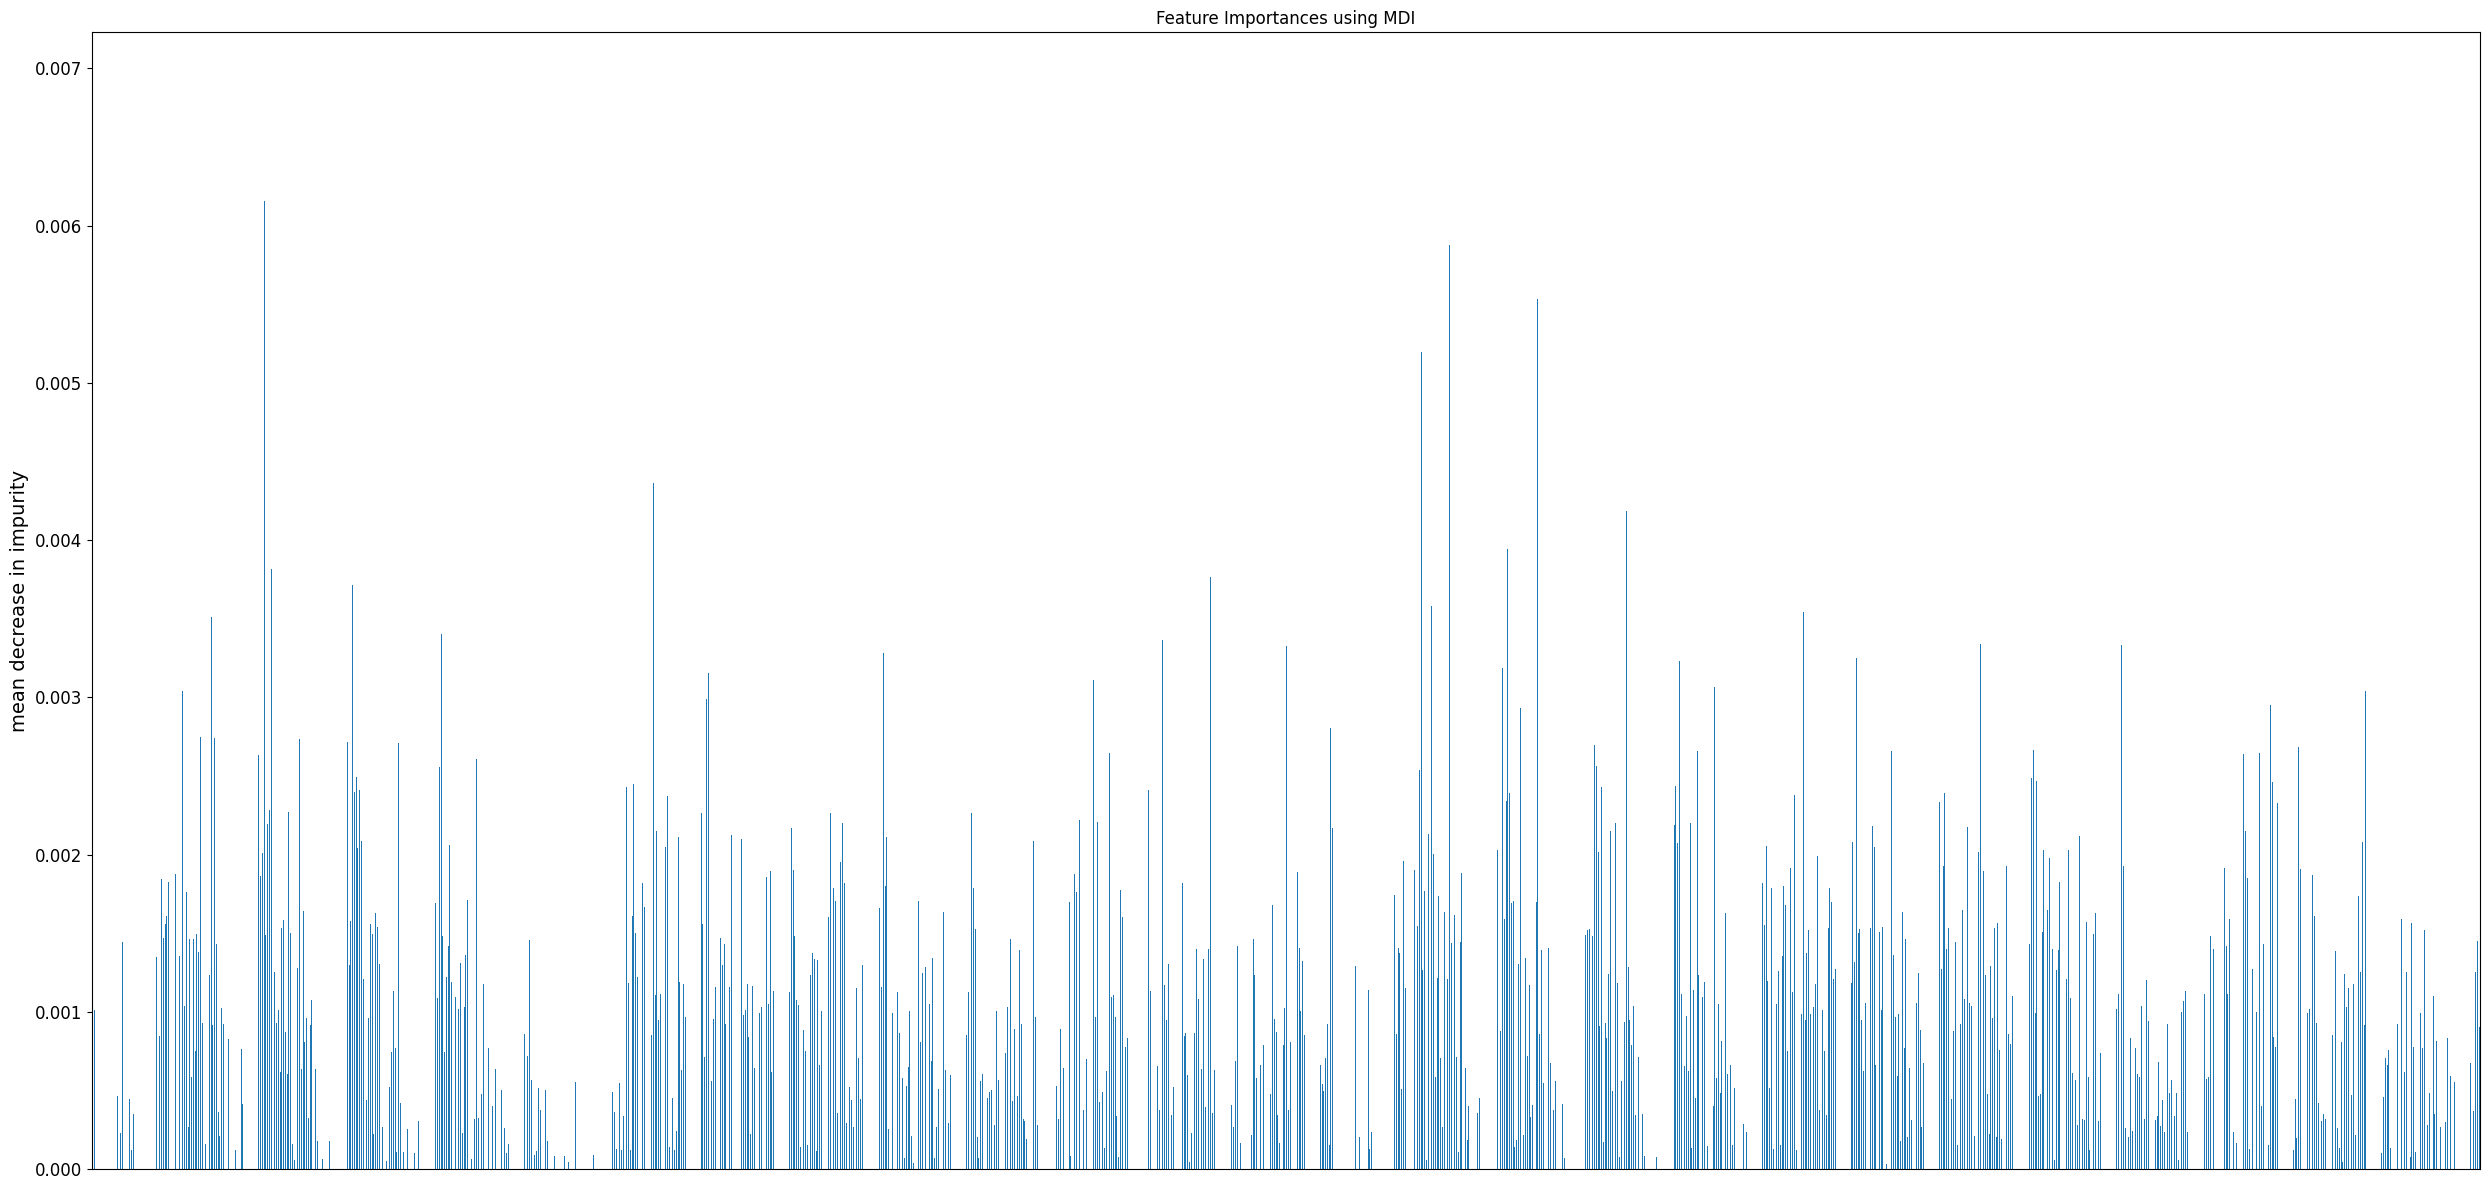

In [67]:
# Measure feature importance
def plot_feature_importances(importances, feat_names):
    df_importances = pd.Series(importances, index=feat_names)
    fig, ax = plt.subplots(figsize=(25, 12))
    df_importances.plot.bar(ax=ax)
    ax.set_title("Feature Importances using MDI")
    ax.set_ylabel("mean decrease in impurity")
    ax.get_xaxis().set_visible(False)
    plt.tight_layout()
    
plot_feature_importances(forest_bayes_search.feature_importances_, X_train.columns)

In [69]:
# Number of features that have impacts
len(forest_bayes_search.feature_importances_[np.where(forest_bayes_search.feature_importances_ > 0.0)[0]])

883